In [2]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import linear_model
import re
import os
import gc
from functools import partial
import itertools
import multiprocessing as mp
from PopulationParameters import PopulationParameters
from Pedigree import Pedigree

class TestCorrelation():
    def __init__(self):
        self.__pp = PopulationParameters()
        self.__ped = Pedigree()

    def read_data(self, required, merged=False, read=False):
        r = {}
        if merged is True:
            pattern_merged = re.compile(r"Merged\ [A-Z]+.csv")
            if len(list(filter(pattern_merged.match, self.__pp.milkrecording_csv))) > 0 and read is True:
                for _file in list(filter(pattern_merged.match, self.__pp.milkrecording_csv)):
                    fname = _file.split()[1].split(".")[0]
                    r[fname] = pd.read_csv(
                        os.path.join(self.__pp.milkrecording_folder, _file), 
                        index_col=0, 
                        header=0
                    )
                return r
            pedigree = self.__pp.pedigree_data()
        _in = self.__pp.read_milkrecording()
        pattern = re.compile(r"[A-Z]{1,}\ 305TL")
        matching = list(filter(pattern.match, _in.keys()))
        for breed in matching:
            _d = _in[breed]
            _data = pd.DataFrame()
            bname = breed.split(" ")[0]
            for parameter in required:
                try:
                    _p = _d.loc[:,parameter]
                    _data = pd.concat([_data, _p], axis=1, sort=False)
                except KeyError:
                    continue
            if len(_data.columns) < 1:
                continue
            elif merged is True:
                self.__pheno = _data
                pattern_ped = re.compile(r"Pedigree\ [A-Za-z\ ]*%s"%re.escape(bname))
                ped_keys = list(filter(pattern_ped.match, pedigree.keys()))
                ped_df = pd.DataFrame()
                for table in ped_keys:
                    _table = pedigree[table]
                    _table.columns = [x.lower() for x in _table.columns]
                    ped_df = pd.concat([ped_df, _table], axis=0)
                ped_df.reset_index(inplace=True, drop=False)
                ped_df = ped_df.loc[:,["Ear tag", "ear tag sire", "ear tag dam", "year of birth"]]
                ped_df.columns = ["Ear tag", "Sire", "Dam", "Year of Birth"]
                ped_df = self.__ped.make_animals_unique(ped_df)
                divided = self.__pp.divide_df(ped_df)
                _r = []
                enc = {
                    "dt": _in['305TL datetime'],
                    "float": ['MILCH_KG', 'FETT_KG', 'EIWEISS_KG']
                }
                with mp.Pool(processes=mp.cpu_count()) as pool:
                    to_execute = partial(
                        self.merge_phenotype_and_pedigree, 
                        enc
                    )
                    _res = [v for v in pool.map(to_execute, divided) if v is not None]
                    if len(_res) > 0:
                        res = pd.concat(_res, axis=0)
                if 'res' in locals():
                    r[bname] = res
                    res.to_csv(
                        os.path.join(self.__pp.milkrecording_folder, f"Merged {bname}.csv")
                    )
                    del res
                    gc.collect()
                else:
                    continue
            else:
                r[bname] = _data
        return r
    
    def merge_phenotype_and_pedigree(self, enc, pedigree):
        """
        This function works along the pedigree index and tries to align this 
        index with repsective values for the phenotype. In case of missing phenotype
        values, these are set to 0.
        """
        r = pd.DataFrame()
        cols = pedigree.columns.tolist() + self.__pheno.columns.tolist()
        for trait in cols:
            if trait in enc['dt']:
                _dtype = 'datetime64[ns]'
            elif trait in enc['float']:
                _dtype = np.float64
            else:
                _dtype = np.int64
            _r = pd.Series(index=np.unique(pedigree.index), name=trait, dtype=_dtype)
            for animal in np.unique(pedigree.index):
                if trait in pedigree.columns:
                    try:
                        _r.loc[animal] = pedigree.loc[animal, trait]
                    except KeyError:
                        _r.loc[animal] = 0
                else:
                    try:
                        data = self.__pheno.loc[animal, trait]
                        if isinstance(data, pd.Series):
                            """
                            The reason for having this condition is that animals can have 
                            multiple records for different lactations, etc..
                            Therefore, it is necessary to ensure that repeated measurements
                            are evaluated correctly, which is done by appending the values to 
                            the resulting series.
                            """
                            _r.append(data, ignore_index=False)
                        else:
                            _r.loc[animal] = data
                    except KeyError:
                        _r.loc[animal] = 0
            r = pd.concat([r, _r], axis=1)
            del _r
            gc.collect()
        for _animal in np.unique(r[r.duplicated()]):
            for column in pedigree.columns:
                try:
                    value = np.unique(pedigree.loc[_animal, column])
                    r.loc[animal, column] = value
                    """
                    In case of repeated measurements, the pedigree records might be missing. To 
                    correct on that, these records are copied in this loop.
                    """
                except KeyError:
                    break
                    # The break statement jumps to the loop running above this loop.
                    # This is not the best solution, but it works suitably fine.
        return r
    
    def test_distribution(self, required, categorical, data=None, save=False):
        if data is None:
            data = self.read_data(required)
        res = pd.DataFrame()
        for breed, values in data.items():
            _res = pd.DataFrame(
                columns=values.columns,
                index=["normal", "binomial"]
            )
            for trait in values.columns:
                if categorical is not None and trait in categorical:
                    continue
                else:
                    for l in _res.index:
                        if "normal" in l:
                            _stats = stats.kurtosis(
                                values.loc[:,trait],
                                axis=None,
                                nan_policy="omit"
                            )
                            """
                            Since the normaltest provided in the scipy.stats() class does not provide
                            satisfactory precision when dealing with natural data, only the kurtosis, which
                            is also part of the normaltest properties, is calculated. Values smaller than 
                            0.2 can be considered to originate from a normal distribution:
                            https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html
                            The paper related to this test is:
                            Distribution of the Kurtosis Statistic b_2 for Normal Samples from F.J. Anscombe and J. Glynn
                            """
                            _res.loc[l, trait] = _stats
                        if "binomial" in l:
                            _l = []
                            """
                            Testing for binomial distributions is especially important when dealing with 
                            categorical data, such as amount of lactations per cow, but it has been adapted to 
                            check the matching of value occurence in datasets in the whole context. Therefore, the 
                            value returns a rather quantitative approach. As a mean of evaluation, the mean of all returned
                            p-values is taken into consideration
                            """
                            for v in np.unique(values.loc[:,trait]):
                                _l.append(
                                    stats.binom_test(len(values[values.loc[:,trait] == v]), len(values.loc[:,trait]), p=0.05)
                                )
                            _res.loc[l, trait] = np.mean(_l)
            _res.index = pd.MultiIndex.from_arrays(
                [
                    list(itertools.repeat(breed, len(_res.index))), 
                    _res.index
                ],
                names=["Breed", "Distributions"]
            )
            res = pd.concat([res, _res], axis=0, sort=False)
        if save is True:
            res.to_csv(f"{self.__pp.milkrecording_folder}/Distribution_{'_'.join(required)}.csv")
        return res

    def test_correlation(self, required, categorical):
        data = self.read_data(required)
        distribution = self.test_distribution(required, categorical, data=data, save=False)
        correlation_values = pd.DataFrame()
        for breed in data.keys():
            breed_distribution = distribution.loc[pd.IndexSlice[breed,:],:]
            breed_data = data[breed]
            correlated = pd.DataFrame(
                index=breed_distribution.columns, 
                columns=breed_distribution.columns
            )
            for measure in breed_distribution.columns:
                for _measure in breed_distribution.columns:
                    if measure and _measure in categorical:
                        continue
                    if measure not in categorical and _measure not in categorical:
                        """
                        The incentive behind this condition is that correlation can not be calculated between categorical values or 
                        between categorical and continuous values
                        """
                        _corr = breed_data.loc[:,[measure, _measure]].corr(method="pearson")
                        """
                        Correlation determination according to Pearson does not take the distribution into account, as 
                        relatedness is not necessarily related to the densitiy function, the values follow
                        https://stats.stackexchange.com/questions/3730/pearsons-or-spearmans-correlation-with-non-normal-data/3733#3733
                        """
                        try:
                            correlated.loc[measure, _measure] = _corr.loc[measure, _measure]
                        except ValueError:
                            if measure in _measure:
                                correlated.loc[measure, _measure] = 1
                            else:
                                continue
                        print(correlated)
                    elif measure in categorical or _measure in categorical:
                        if measure in categorical:
                            _cat_var = measure
                            value = _measure
                            _distribution = self.determine_distribution(
                                breed_distribution, 
                                breed, 
                                _measure
                            )
                            if _distribution is None:
                                print(measure, _measure, breed_distribution, sep="\t")
                        elif _measure in categorical:
                            _cat_var = _measure
                            value = measure
                            _distribution = self.determine_distribution(
                                breed_distribution, 
                                breed, 
                                measure
                            )
                            if _distribution is None:
                                print(measure, _measure, breed_distribution, sep="\t")
                        print(_distribution)
                        if "normal" in _distribution:
                            """
                            Since a correlation between categorical variables and continuous 
                            variables is hard to prove, the easiest way is to make up an ANOVA
                            analysis, which tests, whether the categorical variable makes up for 
                            a significant difference. In case of a non-normal distribution, 
                            Kruskal-Wallis is used.
                            """
                            _idx = required.index(value)
                            if (len(required) - _idx) >= 0:
                                print(required, len(required) - _idx, sep="\t")
                                if (len(required) - _idx) > 0:
                                    ival = (len(required) - _idx) - 1
                                else:
                                    ival = 0
                                if required[ival] not in categorical:
                                    other_value = required[ival]
                                    print(other_value)
                            elif (_idx + 1) <= len(required):
                                print(required, _idx + 1, sep="\t")
                                if required[_idx + 1] not in categorical:
                                    other_value = required[_idx + 1]
                            elif (_idx - 1) <= len(required):
                                print(required, _idx - 1, sep="\t")
                                if required[_idx - 1] not in categorical:
                                    other_value = required[_idx + 1]
                            else:
                                return None
                            """
                            To avoid the ANOVA analysis from running into low confidence interval errors,
                            another variable has been added to the model, without taking these results into
                            further account. 
                            """
                            _data = breed_data.loc[:,[_cat_var, value, other_value]].dropna(how="all", axis=1)
                            _data.replace(np.NaN, 0, inplace=True)
                            _data.sort_values(_cat_var, axis=0, inplace=True)
                            _model = f"{_cat_var} ~ {value} * {other_value}"
                            model = ols(_model, _data)
                            lm = model.fit()
                            table = sm.stats.anova_lm(lm, type=2).F
                            # Directly drawn from the examples on the statsmodels webpage:
                            # https://www.statsmodels.org/stable/anova.html?highlight=anova
                            #corr.loc[measure, _measure] = lm.params.loc[value]
                            # If the regression factors are of interest, these can be accessed 
                            # using the params property on the lm variable. This step returns a 
                            # pd.Series containing regression factors for all variables included 
                            # in the model.
                            print(table)
                            correlated.loc[measure, _measure] = table.loc[value]
                        if "binomial" in _distribution:
                            _data = breed_data.loc[:,[_cat_var, value]].dropna(how="all", axis=1)
                            _data.replace(np.NaN, 0, inplace=True)
                            _data.sort_values(_cat_var, axis=0, inplace=True)
                            _mean = pd.Series(index=np.unique(_data.loc[:,_cat_var]))

                            for fixed in np.unique(_data.loc[:,_cat_var]):
                                try:
                                    _v = _data.loc[_data[_cat_var] == fixed]
                                except KeyError:
                                    print(_cat_var, fixed)
                                    continue
                                _mean.loc[fixed] = _v[value].mean()
                            l = []
                            for _fixed in np.unique(_data.loc[:,_cat_var]):
                                _v = _data.loc[_data[_cat_var] == fixed]
                                _d = _v[value]
                                statistics, p = stats.kruskal(
                                    _d,
                                    _mean.values, 
                                    nan_policy="omit"
                                )
                                # The intention behind this test is to figure out, whether a sample under 
                                # certain fixed conditions deviates from a mean of all fixed conditions
                                l.append(p)
                            print(_cat_var, value, np.quantile(l, 0.25), np.median(l), np.quantile(l, 0.75), sep="\t")
                            correlated.loc[measure, _measure] = np.median(l)
            correlated.index = pd.MultiIndex.from_arrays(
                [list(itertools.repeat(breed, len(correlated.index)))],
                names=["Breed", "Correlation"]
            )
            correlation_values = pd.concat([correlation_values, correlated], axis=0, sort=False)
        return correlation_values

    def determine_distribution(self, breed_distribution, breed, measure):
        if breed_distribution.loc[pd.IndexSlice[breed, "normal"], measure] < 0.2:
            """
            The threshold used in this condition to tell, whether the sample might be derived 
            has been explained in detail previously. It is based, as already declared, on the 
            paper Distribution of the Kurtosis Statistic b_2 for Normal Samples
            """
            return "normal"
        elif breed_distribution.loc[pd.IndexSlice[breed,"normal"], measure] > 0.2 and breed_distribution.loc[pd.IndexSlice[breed,"binomial"], measure] > 0:
            """
            The overall assumption is that all data which is not normally distributed follows a binomial distribution
            """
            return "binomial"
        
    def linear_model(self, fixed, randomized):
        data = self.read_data(fixed + randomized, merged=True, read=True)
        for key, _data in data.items():
            for trait in fixed:
                for _trait in _data.columns:
                    if _trait == trait:
                        continue
                    else:
                        model = linear_model.LinearRegression()
                        #other_traits = [v for v in fixed if v not in trait] + randomized
                        try:
                            fit_ = model.fit(_data[trait].to_numpy().reshape(-1,1), _data.loc[:,_trait].to_numpy())
                        except TypeError:
                            continue
                        print(fit_.coef_)
        
TestCorrelation().linear_model(["KALBEDATUM", "BETRIEB"], ["MILCH_KG", "FETT_KG"])

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


ValueError: could not convert string to float: '2015-01-20 00:00:00'

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


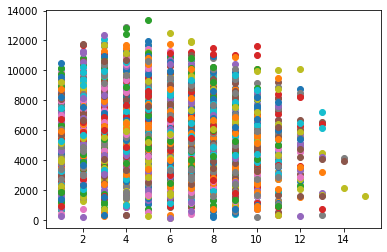

In [5]:
from matplotlib import pyplot as plt

t = TestCorrelation()
d = t.read_data(["MILCH_KG", "LAKT_ZAHL", "BETRIEB"])
_d = d["RDN"]
fig, ax = plt.subplots()
#n, bins, patches = plt.hist(_d["LAKT_ZAHL"], 100, density=True, facecolor="blue")
#_stats = stats.kurtosis(_d["MILCH_KG"], axis=None, nan_policy="omit")
#print(_stats)
for farm in np.unique(_d.loc[:,"BETRIEB"]):
    _sub_d = _d.loc[_d["BETRIEB"] == farm]
    _val = pd.Series(index=np.unique(_sub_d.loc[:,"LAKT_ZAHL"]), dtype=np.float)
    for lact in np.unique(_sub_d.loc[:,"LAKT_ZAHL"]):
        _sub_sub_d = _sub_d.loc[_sub_d["LAKT_ZAHL"] == lact]
        _val.loc[lact] = _sub_sub_d.mean().loc["MILCH_KG"]
    ax.scatter(_val.index, _val.values)
plt.show()

In [6]:
d = TestCorrelation().read_data(["MILCH_KG", "LAKT_ZAHL"])
d["RDN"].corr(method="pearson").loc["MILCH_KG", "LAKT_ZAHL"]

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


0.047577396760989564

In [8]:
from sklearn import model_selection

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

pp = PopulationParameters()
d = pd.read_csv(f"{pp.milkrecording_folder}/RDN_305TL.csv", index_col=0)
print(d)
_d = pd.read_csv(f"{pp.pedigree_folder}pedigree_RDN", sep=" ", header=None, index_col=0, dtype=np.int64)
_d.columns = ["Ear tag sire adapted", "Ear tag dam adapted", "Year of Birth"]
_d = _d.loc[_d["Ear tag sire adapted"] != 0]
d = d.loc[d["ear_tag"] != 0]
d.loc[:,"ear_tag"] = d["ear_tag"].astype(np.int64)
d.index = d["ear_tag"]
d.drop("ear_tag", axis=1, inplace=True)
d.replace(0, np.NaN, inplace=True)
d.dropna(how="all", axis=1, inplace=True)
d2 = pd.merge(d, _d, left_index=True, right_index=True)
farm_values = {farm: d2.loc[d2["BETRIEB"] == farm, "MILCH_KG"].mean() for farm in np.unique(d2["BETRIEB"])}
_max_average = max(list(farm_values.values()))
for cow in np.unique(d2.index):
    _farm = d2.loc[cow, "BETRIEB"]
    d2.loc[cow, "Betriebsschnitt"] = farm_values[_farm]
    d2.loc[cow, "Vergleich"] = farm_values[_farm]/_max_average
train, test = split_train_test(d2, 0.2)

        BETRIEB_3  BETRIEB_2  BETRIEB                                ear_tag  \
0             0.0        0.0  14742.0  (0, Timestamp('2014-07-24 00:00:00'))   
1             0.0        0.0      0.0                                    0.0   
2             0.0        0.0      0.0                                    0.0   
3             0.0        0.0      0.0                                    0.0   
4             0.0        0.0      0.0                                    0.0   
...           ...        ...      ...                                    ...   
190865        0.0        0.0      0.0                                      0   
190866        0.0        0.0      0.0                                      0   
190867        0.0        0.0      0.0                                      0   
190868        0.0        0.0      0.0                                      0   
190869        0.0        0.0      0.0                                      0   

        FETT_KG  FETT_KG_2  FETT_KG_3  

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ValueError: invalid literal for int() with base 10: "(0, Timestamp('2014-07-24 00:00:00'))"

In [3]:
_random = np.random.choice(train.columns, 1)
_train = train.sort_values(_random[0], axis=0)
# This step creates a different dataset on each iteration, therefore avoiding overfitting
# with regard to the data structure
y = pd.Series(data=_train["MILCH_KG"], index=_train.index)
x = _train.drop(["MILCH_KG", "FETT_KG", "BETRIEB"], axis=1)
model = linear_model.LassoLars(alpha=3e-6)
#model = linear_model.LassoLarsCV(cv=100)
_model = linear_model.Lasso(alpha=3e-6)
#_model = linear_model.LassoCV(cv=100)
linear = linear_model.LinearRegression()
_random2 = np.random.choice(test.columns, 1)
_test = test.sort_values(_random2[0], axis=0)
_fitLars = model.fit(x, y)
_fitLasso = _model.fit(x, y)
_fitLinear = linear.fit(x, y)
_fitLars_val = pd.Series(
    data=_fitLars.predict(_test.drop(["MILCH_KG", "FETT_KG", "BETRIEB"], axis=1)), 
    name="LassoLars"
)
_fitLasso_val = pd.Series(
    data=_fitLasso.predict(_test.drop(["MILCH_KG", "FETT_KG", "BETRIEB"], axis=1)), 
    name="Lasso"
)
_fitLinear_val = pd.Series(
    data=_fitLinear.predict(_test.drop(["MILCH_KG", "FETT_KG", "BETRIEB"], axis=1)), 
    name="Linear"
)
res = pd.concat([_fitLars_val, _fitLasso_val], axis=1)
res = pd.concat([res, _fitLinear_val], axis=1)
res = pd.concat([res, test["MILCH_KG"].reset_index(drop=True)], axis=1)
#_fit.score(x, y)
#_fit.get_params()
#_fit.alphas_
_, _, coefs = linear_model.lars_path(x.values, y.values, method="lasso", verbose=True)
#xx = np.sum(np.abs(coefs.T), axis=1)
#df = pd.DataFrame()
#i = 0
#for _val in coefs:
#    __d = pd.Series(data=_val, name=x.columns[i])
#    df = pd.concat([df, __d], axis=1, sort=False)
#    i += 1
res["Deviation LassoLars"] = res["LassoLars"].values - test["MILCH_KG"].values
res["Deviation Lasso"] = res["Lasso"].values - test["MILCH_KG"].values
res["Deviation Linear"] = res["Linear"].values - test["MILCH_KG"].values
_res = res[["Deviation LassoLars", "Deviation Lasso", "Deviation Linear"]]
_r = pd.concat(
    [
        pd.Series(name="Median", data=_res.median(axis=0)), 
        pd.Series(name="Mean", data=_res.mean(axis=0))
    ], axis=1
)
_r = pd.concat(
    [_r, pd.Series(name="Quantile 0.25", data=_res.quantile(0.25, axis=0))], 
    axis=1
)
_r = pd.concat(
    [_r, pd.Series(data=_res.quantile(0.75, axis=0), name="Quantile 0.75")], 
    axis=1
)
_r = pd.concat(
    [_r, pd.Series(data=_res.quantile(0.9, axis=0), name="Quantile 0.9")], 
    axis=1
)
_r = pd.concat(
    [_r, pd.Series(data=_res.quantile(0.1, axis=0), name="Quantile 0.1")], 
    axis=1
)
lasso, = plt.plot(res.index, res.loc[:,"LassoLars"], label="LassoLars")
milch_kg, = plt.plot(res.index, res.loc[:,"MILCH_KG"], label="MILCH_KG")
plt.legend(handles=[lasso, milch_kg])
_r

NameError: name 'train' is not defined

In [11]:
from sklearn import decomposition

transformer = decomposition.FactorAnalysis(n_components=len(d2.columns))
_fit = transformer.fit(d2)
_cov = transformer.get_covariance()
_df = pd.DataFrame()
i = 0
for array in _cov:
    _s = pd.Series(data=array, name=d2.columns[i])
    i += 1
    _df = pd.concat([_df, _s], axis=1, sort=False)
_df.index = d2.columns
_df

BETRIEB       FETT_KG     LAKT_ZAHL      MILCH_KG  \
BETRIEB               5.321627e+08 -3.030496e+00  7.327766e+01 -2.758976e+05   
FETT_KG              -3.030496e+00  4.043013e+03  9.226643e-01  8.730685e+04   
LAKT_ZAHL             7.327766e+01  9.226643e-01  1.919509e-02  1.958090e+01   
MILCH_KG             -2.758976e+05  8.730685e+04  1.958090e+01  2.177211e+06   
Ear tag sire adapted -1.185777e+15  2.646363e+10 -3.906947e+08  7.325890e+13   
Ear tag dam adapted   2.202200e+14  3.554323e-13  8.017424e+08  3.551423e+13   
Year of Birth        -3.808084e+03 -4.079102e+00 -1.030645e-02 -5.292072e+01   
Betriebsschnitt      -2.758976e+05  3.581840e+04  5.359967e+00  8.662616e+05   
Vergleich            -3.153115e+01  4.093531e+00  6.125676e-04  9.900132e+01   

                      Ear tag sire adapted  Ear tag dam adapted  \
BETRIEB                      -1.185777e+15         2.202200e+14   
FETT_KG                       2.646363e+10         3.554323e-13   
LAKT_ZAHL                    -3.906947e+08         8.017424e+08   
MILCH_KG                      7.325890e+13         3.551423e+13   
Ear tag sire adapted          5.429459e+24        -1.162393e+22   
Ear tag dam adapted          -1.162393e+22         2.686520e+23   
Year of Birth                -4.037220e+10        -3.465931e+10   
Betriebsschnitt              -7.897497e+13         3.222300e+13   
Vergleich                    -9.025711e+09         3.682629e+09   

                      Year of Birth  Betriebsschnitt     Vergleich  
BETRIEB               -3.808084e+03    -2.758976e+05 -3.153115e+01  
FETT_KG               -4.079102e+00     3.581840e+04  4.093531e+00  
LAKT_ZAHL             -1.030645e-02     5.359967e+00  6.125676e-04  
MILCH_KG              -5.292072e+01     8.662616e+05  9.900132e+01  
Ear tag sire adapted  -4.037220e+10    -7.897497e+13 -9.025711e+09  
Ear tag dam adapted   -3.465931e+10     3.222300e+13  3.682629e+09  
Year of Birth          1.071121e+00     3.059272e+01  3.496310e-03  
Betriebsschnitt        3.059272e+01     8.662618e+05  9.900130e+01  
Vergleich              3.496310e-03     9.900130e+01  1.131444e-02